<a href="https://colab.research.google.com/github/aetklimatcha/OutfitRecommendationChatbot/blob/main/%EC%BD%94%EB%94%94_%EC%B6%94%EC%B2%9C_%EC%B1%97%EB%B4%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코디 추천 챗봇



In [ ]:
!pip install -q gradio
!pip install -q diffusers transformers accelerate openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.9 MB/s

## Load the model

MUSINSA-IGO (MUSINSA fashion Image Generative Operator)

https://huggingface.co/youngmki/musinsaigo-2.0

In [ ]:
import torch
from diffusers import DiffusionPipeline
import openai
import json

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "youngmki/musinsaigo-2.0"
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16
)
pipe = pipe.to(device)
pipe.load_lora_weights(model_id)

## Prompt helper functions

In [ ]:
def make_prompt(prompt: str) -> str:
    prompt_prefix = "RAW photo, (Christmas Fashion:1.2), (winter:1.1)"
    prompt_suffix = "(high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3"
    return ", ".join([prompt_prefix, prompt, prompt_suffix]).strip()


def make_negative_prompt(negative_prompt: str) -> str:
    negative_prefix = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), \
    text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, \
    extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, \
    bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, \
    extra arms, extra legs, fused fingers, too many fingers, long neck"

    return (
        ", ".join([negative_prefix, negative_prompt]).strip()
        if len(negative_prompt) > 0
        else negative_prefix
    )

## Inference

  0%|          | 0/50 [00:00<?, ?it/s]

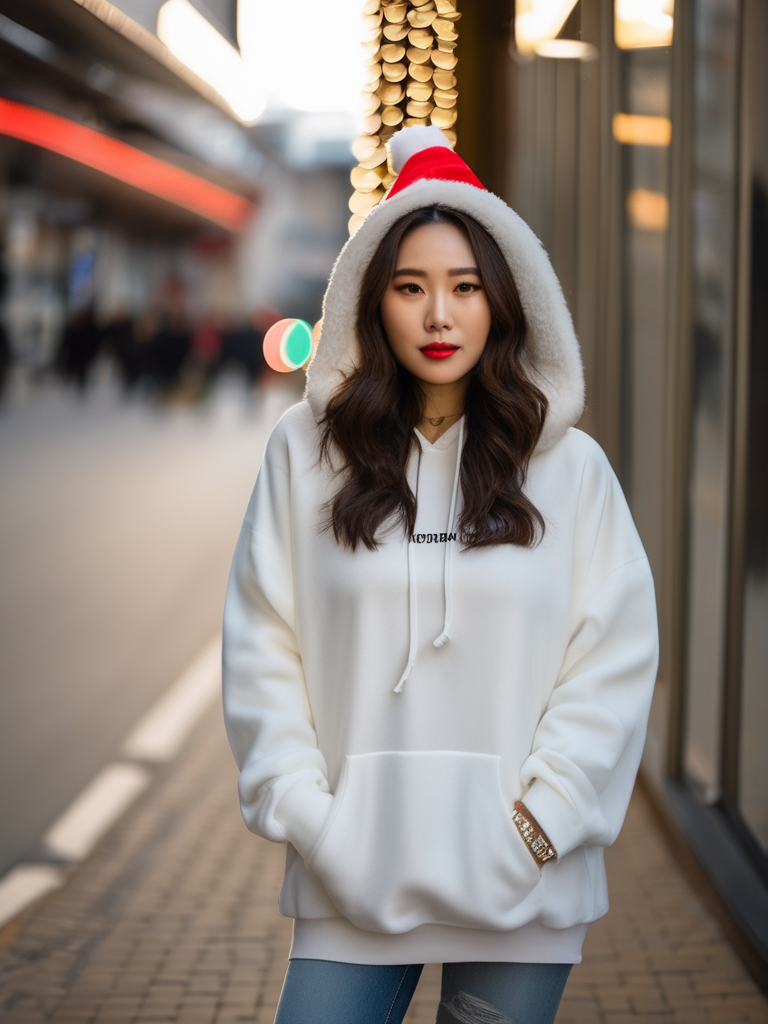

In [ ]:
PROMPT = "A Korean woman in her 20s wearing a white large hoodie in street fashion for Christmas"
NEGATIVE_PROMPT = ""

def generate_image(prompt):
    image = pipe(
        prompt=make_prompt(prompt),
        height=1024,
        width=768,
        num_inference_steps=50,
        guidance_scale=7.5,
        negative_prompt=make_negative_prompt(NEGATIVE_PROMPT),
        cross_attention_kwargs={"scale": 0.75},
    ).images[0]

    return image

generate_image(PROMPT)

## ChatGPT API

### Function Calling

함수를 호출하는 기능

#### Supported models

https://platform.openai.com/docs/guides/function-calling/supported-models

In [ ]:
from openai import OpenAI
import json

#개인 api 키 입력하기
client = OpenAI(api_key='')

model = 'gpt-3.5-turbo-1106'

### 1. 조건이 부족할 때

In [ ]:
gpt_system_prompt = """You're a chatbot that helps people choose what to wear in Christmas. Based on the user's preferences, you need to help them choose the right outfit and print it out as an image. To make outfit recommendations, you need the following information.
- The user's gender
- Nationality
- Age
- Clothing preferences

To create a prompt to generate an image, the process is as follows:
1. Collect information from the user by asking them a number of questions.
2. Once you have enough information, complete the prompt as shown below:
Example input:
- Gender: Female
- Nationality: Korea
- Age: 25
- Preference: Street fashion
Example prompt: A Korean woman in her 20s wearing a white large hoodie in street fashion for Christmas.
3. pass the completed prompt as an argument to call the `generate_image` function.
4. You must answer in Korean and prompt must be in English.
"""

tools = [{
    "type": "function",
    "function": {
        "name": "generate_image",
        "description": "Generate an outfit image from prompt.",
        "parameters": {
            "type": "object",
            "properties": {
                "prompt": {
                    "type": "string",
                    "description": "Prompt that generate an outfit image",
                },
            },
            "required": ["prompt"],
        },
    },
}]

gpt_user_prompt = "크리스마스에 어떤 옷을 입어야할까?"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": gpt_system_prompt},
        {"role": "user", "content": gpt_user_prompt}],
    tools=tools,
    tool_choice="auto",
)

print(completion.choices[0])
print(completion.choices[0].message.content)

Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='알겠습니다. 몇 가지 질문을 드릴게요.\n먼저 성별이 무엇인가요?', role='assistant', function_call=None, tool_calls=None))
알겠습니다. 몇 가지 질문을 드릴게요.
먼저 성별이 무엇인가요?


### 2. 조건을 만족했을 때

In [ ]:
gpt_user_prompt = "크리스마스에 어떤 옷을 입어야할까? 나이: 25세, 국적: 대한민국, 성별: 여성, 취향: 단정함"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": gpt_system_prompt},
        {"role": "user", "content": gpt_user_prompt}],
    tools=tools,
    tool_choice="auto",
)

completion.choices[0]

Choice(finish_reason='tool_calls', index=0, message=ChatCompletionMessage(content='물론이죠! 대한민국에서는 크리스마스에 단정한 스타일의 드레스가 잘 어울릴 것 같아요. 이번 크리스마스를 위해 단정한 분위기의 드레스로 스타일링해보세요. 저는 이를 위한 의상 이미지를 생성할게요. 잠시 기다려주세요.', role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_yunTyc2gy4HaS0jwMciTOjHk', function=Function(arguments='{"prompt": "A Korean woman in her 20s wearing a neat dress for Christmas."}', name='generate_image'), type='function')]))

In [ ]:
completion.choices[0].message.tool_calls[0].function

Function(arguments='{"prompt": "A Korean woman in her 20s wearing a neat dress for Christmas."}', name='generate_image')

### Result

In [ ]:
if completion.choices[0].message.tool_calls is not None:
    function_name = completion.choices[0].message.tool_calls[0].function.name
    arguments = completion.choices[0].message.tool_calls[0].function.arguments
    arguments = json.loads(arguments)

    if function_name == "generate_image":
        print(function_name)
        print(arguments)

generate_image
{'prompt': 'A Korean woman in her 20s wearing a neat dress for Christmas.'}


  0%|          | 0/50 [00:00<?, ?it/s]

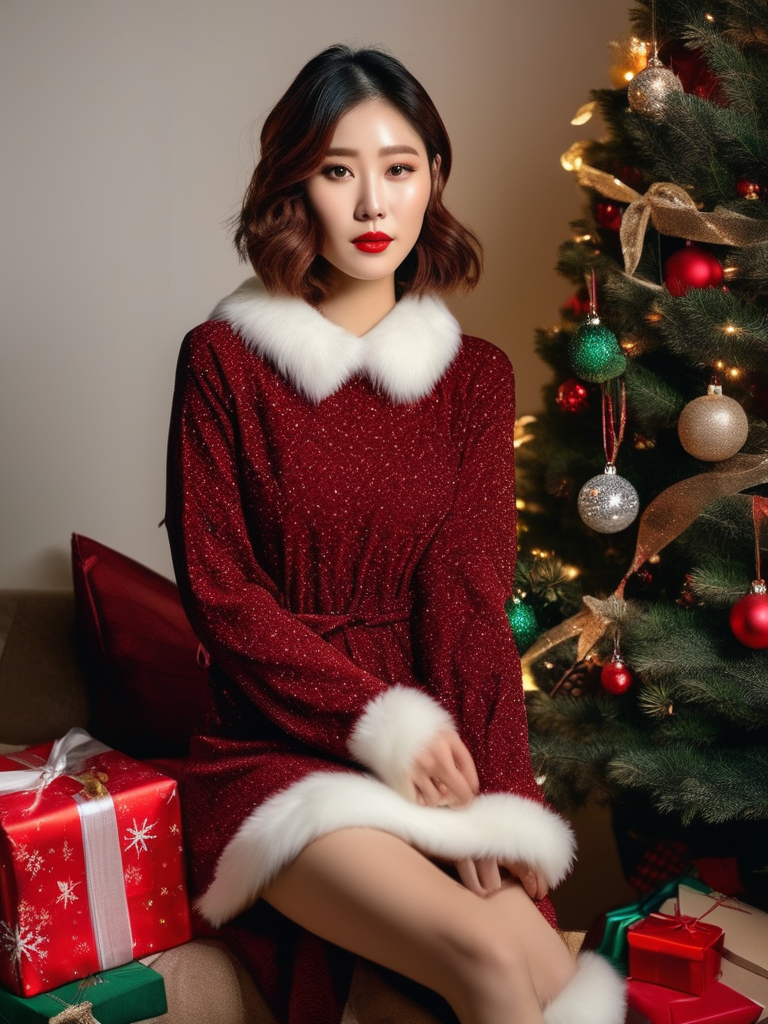

In [ ]:
generate_image(arguments["prompt"])

## Gradio Chatbot

In [ ]:
import gradio as gr

def answer(state, state_chatbot, text):
    messages = state + [{
        "role": "user",
        "content": text
    }]

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        tools=tools,
        tool_choice="auto"
    )

    msg = completion.choices[0].message.content if completion.choices[0].message.content else ""

    new_state = [{
        "role": "user",
        "content": text
    }, {
        "role": "assistant",
        "content": msg
    }]

    state = state + new_state

    if completion.choices[0].message.tool_calls is not None:
        function_name = completion.choices[0].message.tool_calls[0].function.name
        arguments = completion.choices[0].message.tool_calls[0].function.arguments
        arguments = json.loads(arguments)

        if function_name == "generate_image":
            print(arguments)

            img = generate_image(arguments["prompt"])

            img_path = f'image.jpg'
            img.save(img_path)

            state_chatbot = state_chatbot + [(text, (img_path,))]
    else:
        state_chatbot = state_chatbot + [(text, msg)]

    return state, state_chatbot, state_chatbot


with gr.Blocks(css="#chatbot .overflow-y-auto{height:500px}") as demo:
    state = gr.State([{
        "role": "system",
        "content": gpt_system_prompt
    }])
    state_chatbot = gr.State([])

    with gr.Row():
        gr.HTML("""<div style="text-align: center; max-width: 500px; margin: 0 auto;">
            <div>
                <h1>크리스마스에 무슨 옷을 입으면 좋을까</h1>
            </div>
        </div>""")

    with gr.Row():
        chatbot = gr.Chatbot(
            elem_id="chatbot",
            avatar_images=('https://i.imgur.com/B7LuWPp.png', 'https://i.imgur.com/zW0uI5x.png'))

    with gr.Row():
        txt = gr.Textbox(show_label=False, placeholder="크리스마스에 무슨 옷을 입으면 좋을까?", container=False)

    txt.submit(answer, [state, state_chatbot, txt], [state, state_chatbot, chatbot])
    txt.submit(lambda: "" , None, txt)


demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://e34873f9c61ad1788d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


{'prompt': 'A Korean woman in her 20s wearing a clean and stylish outfit for Christmas.'}


  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e34873f9c61ad1788d.gradio.live
